In [1]:
##################################################################################
#                                                                                #
#                                Comparison Notebook                             #
#                                                                                #
##################################################################################

In [2]:
# =====================
# Imports
# =====================
# %load_ext line_profiler
import sys
sys.path.append('..')
sys.path.append('mister_ed') # library for adversarial examples
sys.path.append('CertifiedReLURobustness')
from collections import defaultdict
import geocert_oop as geo
from domains import Domain
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face
import utilities as utils
import os
import time 
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from cvxopt import solvers, matrix
import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import mnist.mnist_loader as  ml 
MNIST_DIM = 784

/home/justin/.conda/envs/DeepL/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [3]:
##################################################################################
#                                                                                #
#                       Network Model + Data Loading                             #
#                                                                                #
##################################################################################

# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def l2_loss(net):
    return sum([_.norm(p=2) for _ in net.parameters() if _.dim() > 1])
  
    
def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([2e-3])
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))

In [4]:
NETWORK_NAME = '17_mnist_small.pkl'
ONE_SEVEN_ONLY = True 
layer_sizes = [MNIST_DIM, 10, 50, 10, 2]

if ONE_SEVEN_ONLY:
    trainset = ml.load_single_digits('train', [1, 7], batch_size=16, 
                                      shuffle=False)  
    valset = ml.load_single_digits('val', [1, 7], batch_size=16, 
                                      shuffle=False)        
else:    
    trainset = ml.load_mnist_data('train', batch_size=128, shuffle=False)
    valset = ml.load_mnist_data('val', batch_size=128, shuffle=False)


try: 
    network = pickle.load(open(NETWORK_NAME, 'rb'))
    net = network.net
    print("Loaded pretrained network")
except:
    print("Training a new network")
    
    network = PLNN([MNIST_DIM, 10, 50, 10, 2])
    net = network.net
    train(net, trainset, 10)
    pickle.dump(network, open(NETWORK_NAME, 'wb'))
    
test_acc(net, valset)    

Loaded pretrained network
Accuracy of: 0.988


In [5]:
# =====================
# Set Images to Verify
# =====================
num_batches = len(valset)
num_batches = 
images = torch.cat([batch_tuple[0] for batch_tuple in valset[0:num_batches]])
labels = torch.cat([batch_tuple[1] for batch_tuple in valset[0:num_batches]])

print('number of images:', len(images))
from CertifiedReLURobustness.Lip_Lin import run_Lip_Lin

number of images: 80


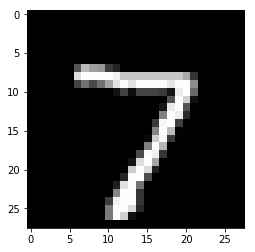

Starting upper bound computation
Upper bound of 5.8754072189331055 in 0.36 seconds
---Initial Polytope---
REJECT DICT:  {'dead_constraints': 63}
Pushed 4/7 facets
---Opening New Polytope---
Bounds  0.5017218436074801   |   5.8754072189331055
REJECT DICT:  {'dead_constraints': 63, 'seen before': 1}
Pushed 2/6 facets
---Opening New Polytope---
Bounds  0.6112450300546508   |   5.8754072189331055
REJECT DICT:  {'dead_constraints': 63, 'seen before': 1}
Pushed 3/6 facets
---Opening New Polytope---
Bounds  0.611304953312115   |   5.8754072189331055
REJECT DICT:  {'dead_constraints': 63, 'seen before': 2}
Pushed 3/5 facets
---Opening New Polytope---
Bounds  0.7075559063906501   |   5.8754072189331055
REJECT DICT:  {'dead_constraints': 63, 'seen before': 1}


KeyboardInterrupt: 

In [6]:
##################################################################################
#                                                                                #
#                       Geocert                                                  #
#                                                                                #
##################################################################################



# Run Geocert on a set of mnist digits
min_dists = []
pgd_dists = []
num_polys = []
poly_maps = []
times = []
for image in images:
        # Builds an object used to to hold algorithm parameters
        cert_obj = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
                                  config_fxn_kwargs={'num_jobs': 1},
                                  hyperbox_bounds=[0.0, 1.0])
    
        plt.gray()
        plt.imshow(image.squeeze())
        plt.show()
        true_label = network(image).squeeze().max(0)[1].item()
        # Run Geocert 
        start = time.time()
        output = cert_obj.min_dist(image.view(1, -1), lp_norm='l_2', compute_upper_bound=
                                   {"optimizer_kwargs": {"lr": 0.005}, "num_iterations": 100})
        lp_dist, adv_ex_bound, adv_ex, best_example, boundary_facet, seen_poly_map = output
        end = time.time() 
        
        min_dists.append(lp_dist)
        pgd_dists.append(adv_ex_bound)
        print('TIME', end-start)
        times.append(end-start)
        num_polys.append(len(seen_poly_map))
        poly_maps.append(seen_poly_map)

In [ ]:
# =====================
# Save Output
# =====================

output_dictionary = {'min_dists': min_dists , 'pgd_dists': pgd_dists, 'num_polys': num_polys,
                    'poly_maps': poly_maps, 'times': times}

# cwd = os.getcwd()
# filename = cwd + "/Data/Geocert_out.pkl"
# f = open(filename, 'wb')
# pickle.dump(output_dictionary, f)
    

In [ ]:
# =====================
# Imports
# =====================
import numpy as np
from CertifiedReLURobustness.save_nlayer_weights import NLayerModel_comparison
import tensorflow as tf
from CertifiedReLURobustness.Lip_Lin import run_Lip_Lin

In [ ]:
# # ##################################################################################
# # #                                                                                #
# # #                       Fast-Lin / Fast-Lip                                      #
# # #                                                                                #
# # ##################################################################################

# tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# with tf.Session() as sess:


#     # =====================
#     # Convert Network
#     # =====================
#     params = layer_sizes[1:-1]
#     nlayers = len(params)
#     restore = [None]
#     for fc in network.fcs:
#         weight = utils.as_numpy(fc.weight).T
#         bias = utils.as_numpy(fc.bias)
#         restore.append([weight, bias])
#         restore.append(None)

# #     FL_network = NLayerModel_comparison(params, restore=restore, session=sess)
#     FL_network = NLayerModel_comparison(params, session=sess)

In [ ]:
# # =====================
# # Convert Images
# # =====================
# images_lin_lip = utils.as_numpy(images.reshape(-1, 28, 28,1))

In [ ]:
# # ==================================
# # Run Fast-Lin / Fast-Lip on Images
# # ==================================

# true_labels = []
# targets = []
# for label in labels:
#     if label == 0:
#         true_labels.append([1.0, 0.0])
#         targets.append([0.0, 1.0])
#     elif label ==1:
#         true_labels.append([0.0, 1.0])
#         targets.append([1.0, 0.0])
# true_ids = [num for num in range(0,np.shape(images)[0]+1)]
# inputs = images_lin_lip


# min_dists, times  = run_Lip_Lin(FL_network, inputs, targets, true_labels, true_ids, norm='2', numlayer=len(params))


In [ ]:
# =====================
# Load and Display Output
# =====================

# output_dictionary = {'min_dists': min_dists , 'pgd_dists': pgd_dists, 'num_polys': num_polys,
#                     'poly_maps': poly_maps, 'times': times}
# cwd = os.getcwd()
# filename = cwd + "/Data/save/Geocert_out.pkl"
# f = open(filename,"rb")
# output_dictionary = pickle.load(f)
# f.close()